In [1]:
import pandas as pd
#pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

import re
#from numpy import triu
#from scipy.linalg import triu
from gensim.models import Word2Vec
import openai
from sklearn.svm import SVC
from secret_key import openai_key
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsta0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
##df_tweets = pd.read_csv('training.1600000.processed.noemoticon.csv', 
df_tweets = pd.read_csv('balanced.csv', 
                    encoding='latin-1',  names=['target','ids','date','flag','user','text'])

In [40]:
df_tweets.sample(10)

,target,ids,date,flag,user,text
858261.0,4,1574107708,Tue Apr 21 04:16:36 PDT 2009,NO_QUERY,cl4irethomas,@AdamParnell HOW VERY DARE YOU!! I love the Co...
727249.0,0,2262780710,Sat Jun 20 23:13:10 PDT 2009,NO_QUERY,azmelanie,My knee hurts!!
226201.0,0,1977802268,Sat May 30 21:44:38 PDT 2009,NO_QUERY,AmyJade,@asolomon15 haha forgot had a lobster tail too...
65236.0,0,1690897743,Sun May 03 16:37:49 PDT 2009,NO_QUERY,judy_bug,Wanted 2 c Ghosts of Girlfriends Past this wke...
1297071.0,4,2004430151,Tue Jun 02 08:11:20 PDT 2009,NO_QUERY,srk_SaY13,@cooldude_decent hey
88852.0,0,1755057792,Sun May 10 08:08:35 PDT 2009,NO_QUERY,bearwiredpair,I re raise stiff BB pushes and I call... and g...
1103636.0,4,1971064534,Sat May 30 06:06:30 PDT 2009,NO_QUERY,PaulCarterJr,@johna404 It wasn't until I started tweeting t...
151656.0,0,1932562228,Tue May 26 21:43:24 PDT 2009,NO_QUERY,Grey_Archer,@Mommentator shhh. I'm a KC transplant in St. ...
1214429.0,4,1989445685,Mon Jun 01 01:34:11 PDT 2009,NO_QUERY,TheJeffster,AWESOME PRESENT!!! Cyn got me the coolest earl...
1527382.0,4,2177181683,Mon Jun 15 05:37:05 PDT 2009,NO_QUERY,AnnaArco,@venite @rosamundi Laughing v hard..


In [41]:
df_tweets = df_tweets[['target', 'text']]

# Preprocessing

In [42]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, and special chars
    text = re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords/stem
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_tweets['cleaned_text'] = df_tweets['text'].apply(preprocess)

In [47]:
df_tweets['target'] = df_tweets['target'].replace(4, 1)

In [48]:
df_tweets.to_csv('sample_tweets_cleaned.csv', encoding='utf-8', index=False)

# Feature representation

In [49]:
df_tweets_cleaned = pd.read_csv("sample_tweets_cleaned.csv")

In [50]:
df_tweets_cleaned = df_tweets_cleaned[['target', 'cleaned_text']]

df_tweets_cleaned.sample(5)

,target,cleaned_text
25094,0,tummi kinda upset
13644,1,im good today sunni im feelin good
37597,0,ginko tree nowher put gift still pot
41975,0,six flag uuuugh b work bummer
41793,0,dont feel good need make money


In [51]:
df_tweets_cleaned['cleaned_text'] = df_tweets_cleaned['cleaned_text'].fillna('tree').astype(str)

In [52]:
X = df_tweets_cleaned['cleaned_text']
y = df_tweets_cleaned['target']

X_train_tf_idf, X_test_tf_idf, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train_tf_idf.shape, X_test_tf_idf.shape, y_train.shape, y_test.shape

((35000,), (15001,), (35000,), (15001,))

In [ ]:
#X_train = X_train.fillna("")
#X_test = X_test.fillna("")

## TF-IDF

In [53]:
featurizer = TfidfVectorizer()

X_train_tf_idf = featurizer.fit_transform(X_train_tf_idf)
X_test_tf_idf  = featurizer.transform(X_test_tf_idf)

In [54]:
X_train_tf_idf

<35000x26314 sparse matrix of type '<class 'numpy.float64'>'
	with 242818 stored elements in Compressed Sparse Row format>

## Word2Vec

In [55]:
# Tokenize for Word2Vec
sentences = [text.split() for text in df_tweets_cleaned['cleaned_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Document embedding (average word vectors)
def document_vector(text):
    words = text.split()
    return np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv], axis=0)
    '''
    word_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    
    if len(word_vecs) == 0:
        return np.zeros(w2v_model.vector_size)
    
    return np.mean(word_vecs, axis=0)
    '''

X_w2v = np.array([document_vector(text) for text in df_tweets_cleaned['cleaned_text']])

In [56]:
X_w2v

array([[-0.36003044,  0.5525294 ,  0.19089608, ..., -0.30058205,
        -0.01581067, -0.19256975],
       [-0.17160274,  0.40509924,  0.07809062, ..., -0.23589559,
         0.00511796, -0.2964708 ],
       [-0.35598972,  0.51074964,  0.5025056 , ..., -0.45526686,
         0.22664972, -0.17064701],
       ...,
       [-0.3226014 ,  0.52064157,  0.2140873 , ..., -0.40946135,
        -0.01199532, -0.19287357],
       [-0.31390053,  0.5173244 ,  0.51131934, ..., -0.5107945 ,
         0.21328993, -0.3093107 ],
       [-0.27052668,  0.52592725,  0.26021627, ..., -0.33624983,
         0.14500563, -0.18452625]], dtype=float32)

In [57]:
pd.Series(df_tweets_cleaned['cleaned_text']).isna().sum()

0

In [58]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.3, random_state=123)

X_train_w2v.shape, X_test_w2v.shape, y_train.shape, y_test.shape

((35000, 100), (15001, 100), (35000,), (15001,))

## GPT

In [6]:
openai.api_key = openai_key

In [7]:
# Use OpenAI's API (requires API key)
def get_gpt_embedding(text):
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    return np.array(response['data'][0]['embedding'])

X_gpt = np.array([get_gpt_embedding(text) for text in df_tweets_cleaned['cleaned_text']])

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

In [8]:
!pip install transformers sentence-transformers

  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.4 MB 2.4 MB/s eta 0:00:05
   ---- ----------------------------------- 1.0/10.4 MB 2.8 MB/s eta 0:00:04
   ------ --------------------------------- 1.6/10.4 MB 2.5 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/10.4 MB 2.7 MB/s eta 0:00:04
   ---------- ----------------------------- 2.6/10.4 MB 2.7 MB/s eta 0:00:03
   ------------- -------------------------- 3.4/10.4 MB 2.8 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.4 MB 2.7 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.4 MB 2.7 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/10.4 MB 2.7 MB/s eta 0:00:03
   ------------------- --

In [59]:
# Load a lightweight BERT-based model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and great for embeddings

# Ensure cleaned text is a list of strings
texts = df_tweets_cleaned['cleaned_text'].fillna('').astype(str).tolist()

# Generate embeddings
X_bert = model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

In [60]:
X_bert

array([[ 0.00735882,  0.02461563, -0.0035693 , ..., -0.07428308,
        -0.05914465,  0.06149549],
       [-0.09271237,  0.05938389, -0.0003064 , ..., -0.02200666,
        -0.01173835,  0.00805329],
       [-0.11707271,  0.0931607 , -0.00400468, ...,  0.01039946,
         0.0385058 , -0.01901468],
       ...,
       [-0.04697543,  0.04951281, -0.00885349, ..., -0.07697979,
        -0.00906603, -0.09044791],
       [-0.03137401, -0.0426203 , -0.03581215, ..., -0.16683675,
        -0.06879416, -0.07872725],
       [-0.12055019, -0.06212713,  0.02691903, ...,  0.01655738,
        -0.13018261,  0.01602079]], dtype=float32)

In [61]:
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.3, random_state=123)

X_train_bert.shape, X_test_bert.shape, y_train.shape, y_test.shape

((35000, 384), (15001, 384), (35000,), (15001,))

# Classification

In [ ]:
# Initialize SVM
svm = SVC(kernel='rbf')

# Train/test for each feature:
# TF-IDF
'''svm.fit(X_train, y_train)
y_pred_tfidf = svm.predict(X_test)
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred_tfidf))

# Word2Vec
svm.fit(X_train_w2v, y_train)
y_pred_w2v = svm.predict(X_test_w2v)
print("Word2Vec Accuracy:", accuracy_score(y_test, y_pred_w2v))'''

# bert embeddin
svm.fit(X_train_bert, y_train)
y_pred_gpt = svm.predict(X_test_bert)
print("GPT Accuracy:", accuracy_score(y_test, y_pred_gpt))

GPT Accuracy: 0.7482834477701487


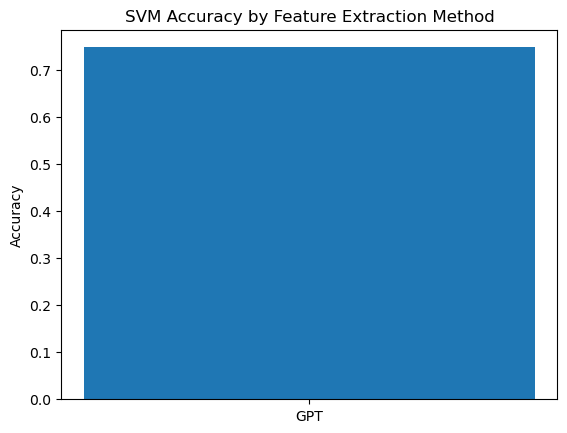

In [63]:
accuracies = {
    #'TF-IDF': accuracy_score(y_test, y_pred_tfidf),
    #'Word2Vec': accuracy_score(y_test, y_pred_w2v),
    'GPT': accuracy_score(y_test, y_pred_gpt)
}

plt.bar(accuracies.keys(), accuracies.values())
plt.title('SVM Accuracy by Feature Extraction Method')
plt.ylabel('Accuracy')
plt.show()

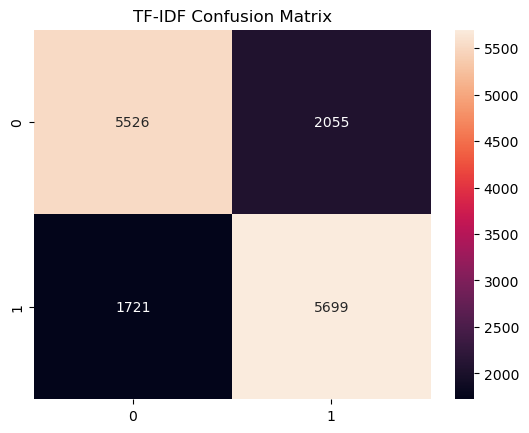

In [64]:
# Confusion Matrix (example for bert)
sns.heatmap(confusion_matrix(y_test, y_pred_gpt), annot=True, fmt='d')
plt.title('TF-IDF Confusion Matrix')
plt.show()

In [66]:
print(classification_report(y_test, y_pred_gpt))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      7581
           1       0.73      0.77      0.75      7420

    accuracy                           0.75     15001
   macro avg       0.75      0.75      0.75     15001
weighted avg       0.75      0.75      0.75     15001

